In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !mkdir dataset
# !mkdir dataset
# !unzip drive/MyDrive/mapaton2022/TrainData.zip
# !unzip drive/MyDrive/mapaton2022/ValidData.zip
# !unzip drive/MyDrive/mapaton2022/TestData.zip
!cp drive/MyDrive/mapaton2022/dataset/train.txt train.txt
!cp drive/MyDrive/mapaton2022/dataset/valid.txt valid.txt
!cp drive/MyDrive/mapaton2022/dataset/test.txt test.txt
!cp drive/MyDrive/mapaton2022/model/Networks.py Networks.py
# !cp exp/batch4500_F1_7434.pth drive/MyDrive/mapaton2022/exp/batch4500_F1_7434.pth

## Leer dataset

In [1]:
import numpy as np
import pandas as pd
import requests
import re
import os
import h5py

In [25]:
path_img = r'TrainData/img/image_35.h5'
mask_img = r'TrainData/mask/mask_35.h5'

with h5py.File(path_img, 'r') as hf_img:
    image = hf_img['img'][:]

with h5py.File(mask_img, 'r') as hf_mask:
    label = hf_mask['mask'][:]

In [26]:
image.shape

(128, 128, 14)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


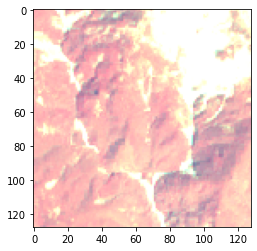

In [27]:
import matplotlib.pyplot as plt
plt.imshow(image[:,:,[4,3,1]])

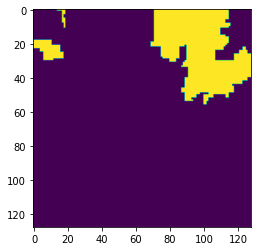

In [28]:
plt.imshow(label)

## Dataloader

In [33]:
# Read train data
data_dir = r""
list_path = r"dataset/train.txt"
max_iters = None
set = 'labeled'
img_ids = [i_id.strip() for i_id in open(list_path)]

if not max_iters == None:
    n_repeat = int(np.ceil(max_iters / len(img_ids)))
    img_ids = img_ids * n_repeat + img_ids[:max_iters-n_repeat*len(img_ids)]

files = []

if set == 'labeled':
    for name in img_ids:
        img_file = data_dir + name
        label_file = data_dir + name.replace('img','mask').replace('image','mask')
        files.append({
            'img': img_file,
            'label': label_file
        })
elif set == 'unlabeled':
    for name in img_ids:
        img_file = data_dir + name
        files.append({
            'img': img_file
        })

In [36]:
data = pd.DataFrame(files)
data.head()

,img,label
0,TrainData/img/image_1.h5,TrainData/mask/mask_1.h5
1,TrainData/img/image_2.h5,TrainData/mask/mask_2.h5
2,TrainData/img/image_3.h5,TrainData/mask/mask_3.h5
3,TrainData/img/image_4.h5,TrainData/mask/mask_4.h5
4,TrainData/img/image_5.h5,TrainData/mask/mask_5.h5


In [37]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [51]:
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
data_dir, list_path, max_iters=None, set='labeled'

In [147]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import h5py

from skimage import exposure

IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
CHANNELS = 14

BATCH_SIZE = 10

class CustomDataGen(keras.utils.Sequence):
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(512, 512, 14),
                 shuffle=True):
        ################
        self.mean = [-0.4914, -0.3074, -0.1277, -0.0625, 0.0439, 0.0803, 0.0644, 0.0802, 0.3000, 0.4082, 0.0823, 0.0516, 0.3338, 0.7819]
        self.std = [0.9325, 0.8775, 0.8860, 0.8869, 0.8857, 0.8418, 0.8354, 0.8491, 0.9061, 1.6072, 0.8848, 0.9232, 0.9018, 1.2913]
        ################
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle

        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
        with h5py.File(path, 'r') as hf_img:
            image_arr = hf_img['img'][:]
        
        image = np.asarray(image_arr, np.float32)
        image = image.transpose((-1, 0, 1))
        
        for i in range(len(self.mean)):
                image[i,:,:] -= self.mean[i]
                image[i,:,:] /= self.std[i]
        return image
    
    def __get_output(self, path):
        with h5py.File(path, 'r') as hf_lab:
            image_arr = hf_lab['mask'][:]
        label = np.asarray(image_arr, np.float32)
        return label
    
    def __get_data(self, batches):
        batches_x = batches[self.X_col]
        batches_y = batches[self.y_col]

        X_batch = np.asarray([self.__get_input(x) for x in batches_x])
        y_batch = np.asarray([self.__get_output(y) for y in batches_y])
        
        return X_batch, y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [148]:
train_loader = CustomDataGen(train_data,
                            X_col="img",
                            y_col="label",
                            batch_size=BATCH_SIZE, input_size=IMG_SIZE)

In [151]:
channels_sum, channel_squared_sum = 0,0
for data,_ in train_loader:
    channels_sum += tf.reduce_mean(data, axis=[0,2,3])
    channel_squared_sum += tf.reduce_mean(data**2, axis=[0,2,3])

mean = channels_sum/BATCH_SIZE
std = (channel_squared_sum/BATCH_SIZE - mean**2)**0.5
print(mean,std)

tf.Tensor(
[46.041794 42.475525 37.00712  34.939674 33.509182 34.680172 35.283024
 34.537804 29.086676 14.408032 33.163704 32.383186 30.765945 20.350313], shape=(14,), dtype=float32) tf.Tensor([nan nan nan nan nan nan nan nan nan nan nan nan nan nan], shape=(14,), dtype=float32)


### Modelo

In [167]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import concatenate, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.utils import plot_model

In [ ]:
# def double_conv(x, in_channels, out_channels, mid_channels=None):
#     model = Sequential()
#     model.add(Conv2D(in_channels, mid_channels, padding = 1))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv2D(mid_channels, out_channels, padding = 1))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     return model(x)

# def downsample(x, in_channels, out_channels):
#     model = Sequential()
#     model.add(MaxPool2D(2))
#     model.add(double_conv(x, in_channels, out_channels))
#     return model(x)

# def upsample(x, in_channels, out_channels, bilinear=True):
#     model = Sequential()
#     if bilinear == True:
#         model.add(UpSampling2D(2, interpolation = 'bilinear'))
#         model.add(double_conv(x, in_channels, out_channels, in_channels // 2))
#     else:
#         model.add(Conv2DTranspose(in_channels, in_channels // 2, strides=2))
#         model.add(double_conv(x, in_channels, out_channels))
#     return model

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding=1, strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding=1, strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding=1, strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    inputs = keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_SIZE))
    
    p0 = inputs
    c1, p1 = down_block(p0, 64) #512 -> 256
    c2, p2 = down_block(p1, 128) #256 -> 128
    c3, p3 = down_block(p2, 256) #128 -> 64
    c4, p4 = down_block(p3, 512) #64->32
    
    bn = bottleneck(p4, 1024)
    
    u1 = up_block(bn, c4, 512) #32 -> 64
    u2 = up_block(u1, c3, 256) #64 -> 128
    u3 = up_block(u2, c2, 128) #128 -> 256
    u4 = up_block(u3, c1, 64) #256 -> 512
    
    outputs = Conv2D(1, (1, 1), padding=1, activation="sigmoid")(u4)
    model = Model(inputs, outputs)
    return model

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class unet(nn.Module):
    def __init__(self, n_classes, n_channels=14, bilinear=True):
        super(unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [ ]:
import numpy as np

def eval_image(predict,label,num_classes):
    index = np.where((label>=0) & (label<num_classes))
    predict = predict[index]
    label = label[index] 
    
    TP = np.zeros((num_classes, 1))
    FP = np.zeros((num_classes, 1))
    TN = np.zeros((num_classes, 1))
    FN = np.zeros((num_classes, 1))
    
    for i in range(0,num_classes):
        TP[i] = np.sum(label[np.where(predict==i)]==i)
        FP[i] = np.sum(label[np.where(predict==i)]!=i)
        TN[i] = np.sum(label[np.where(predict!=i)]!=i)
        FN[i] = np.sum(label[np.where(predict!=i)]==i)        
    
    return TP,FP,TN,FN,len(label)

### Train

In [ ]:
import numpy as np
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.backends.cudnn as cudnn
import importlib

name_classes = ['Non-Landslide','Landslide']
epsilon = 1e-14

def importName(modulename, name):
    """ Import a named object from a module in the context of this function.
    """
    try:
        module = __import__(modulename, globals(), locals(  ), [name])
    except ImportError:
        return None
    return vars(module)[name]

def main():
    data_dir = r''
    model_module = 'Networks'
    model_name = 'unet'
    train_list = 'train.txt'
    test_list = 'valid.txt'
    input_size = '128,128'
    num_classes = 2
    batch_size = 32
    num_workers = 4
    learning_rate = 1e-3
    num_steps = 5000
    num_steps_stop = 5000
    weight_decay = 5e-4
    gpu_id = 0
    snapshot_dir = 'exp/'

    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    snapshot_dir = snapshot_dir
    if os.path.exists(snapshot_dir)==False:
        os.makedirs(snapshot_dir)

    w, h = map(int, input_size.split(','))
    input_size = (w, h)

    cudnn.enabled = True
    cudnn.benchmark = True
    
    # Create network   
    model_import = importName(model_module, model_name)
    model = model_import(n_classes=num_classes)
    model.train()
    model = model.cuda()

    src_loader = data.DataLoader(
                    LandslideDataSet(data_dir, train_list, max_iters=num_steps_stop*batch_size,set='labeled'),
                    batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)


    test_loader = data.DataLoader(
                    LandslideDataSet(data_dir, train_list, set='labeled'),
                    batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=True)


    optimizer = optim.Adam(model.parameters(),
                        lr=learning_rate, weight_decay=weight_decay)
    
    interp = nn.Upsample(size=(input_size[1], input_size[0]), mode='bilinear')
    
    hist = np.zeros((num_steps_stop,3))
    F1_best = 0.5    
    cross_entropy_loss = nn.CrossEntropyLoss(ignore_index=255)

    for batch_id, src_data in enumerate(src_loader):
        if batch_id==num_steps_stop:
            break
        tem_time = time.time()
        model.train()
        optimizer.zero_grad()
        
        images, labels, _, _ = src_data
        images = images.cuda()      
        pred = model(images)   
        
        pred_interp = interp(pred)
              
        # CE Loss
        labels = labels.cuda().long()
        cross_entropy_loss_value = cross_entropy_loss(pred_interp, labels)
        _, predict_labels = torch.max(pred_interp, 1)
        predict_labels = predict_labels.detach().cpu().numpy()
        labels = labels.cpu().numpy()
        batch_oa = np.sum(predict_labels==labels)*1./len(labels.reshape(-1))

            
        hist[batch_id,0] = cross_entropy_loss_value.item()
        hist[batch_id,1] = batch_oa
        
        cross_entropy_loss_value.backward()
        optimizer.step()

        hist[batch_id,-1] = time.time() - tem_time

        if (batch_id+1) % 10 == 0: 
            print('Iter %d/%d Time: %.2f Batch_OA = %.1f cross_entropy_loss = %.3f'%(batch_id+1,num_steps,10*np.mean(hist[batch_id-9:batch_id+1,-1]),np.mean(hist[batch_id-9:batch_id+1,1])*100,np.mean(hist[batch_id-9:batch_id+1,0])))
           
        # evaluation per 500 iterations
        if (batch_id+1) % 500 == 0:            
            print('Testing..........')
            model.eval()
            TP_all = np.zeros((num_classes, 1))
            FP_all = np.zeros((num_classes, 1))
            TN_all = np.zeros((num_classes, 1))
            FN_all = np.zeros((num_classes, 1))
            n_valid_sample_all = 0
            F1 = np.zeros((num_classes, 1))
        
            for _, batch in enumerate(test_loader):  
                image, label,_, name = batch
                label = label.squeeze().numpy()
                image = image.float().cuda()
                
                with torch.no_grad():
                    pred = model(image)

                _,pred = torch.max(interp(nn.functional.softmax(pred,dim=1)).detach(), 1)
                pred = pred.squeeze().data.cpu().numpy()                       
                               
                TP,FP,TN,FN,n_valid_sample = eval_image(pred.reshape(-1),label.reshape(-1),num_classes)
                TP_all += TP
                FP_all += FP
                TN_all += TN
                FN_all += FN
                n_valid_sample_all += n_valid_sample

            OA = np.sum(TP_all)*1.0 / n_valid_sample_all
            for i in range(num_classes):
                P = TP_all[i]*1.0 / (TP_all[i] + FP_all[i] + epsilon)
                R = TP_all[i]*1.0 / (TP_all[i] + FN_all[i] + epsilon)
                F1[i] = 2.0*P*R / (P + R + epsilon)
                if i==1:
                    print('===>' + name_classes[i] + ' Precision: %.2f'%(P * 100))
                    print('===>' + name_classes[i] + ' Recall: %.2f'%(R * 100))                
                    print('===>' + name_classes[i] + ' F1: %.2f'%(F1[i] * 100))

            mF1 = np.mean(F1)            
            print('===> mean F1: %.2f OA: %.2f'%(mF1*100,OA*100))

            if F1[1]>F1_best:
                F1_best = F1[1]
                # save the models        
                print('Save Model')                     
                model_name = 'batch'+repr(batch_id+1)+'_F1_'+repr(int(F1[1]*10000))+'.pth'
                torch.save(model.state_dict(), os.path.join(snapshot_dir, model_name))

In [ ]:
main()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iter 10/5000 Time: 15.95 Batch_OA = 86.7 cross_entropy_loss = 0.490
Iter 20/5000 Time: 3.32 Batch_OA = 96.9 cross_entropy_loss = 0.287
Iter 30/5000 Time: 3.33 Batch_OA = 98.6 cross_entropy_loss = 0.171
Iter 40/5000 Time: 3.34 Batch_OA = 98.4 cross_entropy_loss = 0.130
Iter 50/5000 Time: 3.37 Batch_OA = 98.5 cross_entropy_loss = 0.102
Iter 60/5000 Time: 3.37 Batch_OA = 98.5 cross_entropy_loss = 0.089
Iter 70/5000 Time: 3.37 Batch_OA = 98.3 cross_entropy_loss = 0.085
Iter 80/5000 Time: 3.37 Batch_OA = 98.4 cross_entropy_loss = 0.073
Iter 90/5000 Time: 3.42 Batch_OA = 98.6 cross_entropy_loss = 0.063
Iter 100/5000 Time: 3.42 Batch_OA = 98.6 cross_entropy_loss = 0.057
Iter 110/5000 Time: 3.44 Batch_OA = 98.3 cross_entropy_loss = 0.060
Iter 120/5000 Time: 3.39 Batch_OA = 98.5 cross_entropy_loss = 0.053
Iter 130/5000 Time: 3.43 Batch_OA = 98.5 cross_entropy_loss = 0.052
Iter 140/5000 Time: 3.44 Batch_OA = 98.7 cross_entropy_loss = 0.046
Iter 150/5000 Time: 3.46 Batch_OA = 98.6 cross_entropy_l

In [ ]:
!cp exp/batch5000_F1_7441.pth drive/MyDrive/mapaton2022/exp/batch5000_F1_7441.pth

## Predict

In [ ]:
import argparse
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils import data
import torch.backends.cudnn as cudnn
import h5py

name_classes = ['Non-Landslide','Landslide']
epsilon = 1e-14

def importName(modulename, name):
    """ Import a named object from a module in the context of this function.
    """
    try:
        module = __import__(modulename, globals(), locals(  ), [name])
    except ImportError:
        return None
    return vars(module)[name]


In [ ]:
!mv img/ TestData/

In [ ]:
data_dir = ''
model_module ='Networks'
model_name ='unet'
test_list ='test.txt'
input_s ='128,128'
num_classes = 2
num_workers = 0
gpu_id = 0
snapshot_dir = 'test_map/'
restore_from ='exp/batch5000_F1_7441.pth'

def main():
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    if os.path.exists(snapshot_dir)==False:
        os.makedirs(snapshot_dir)

    w, h = map(int, input_s.split(','))
    input_size = (w, h)

    cudnn.enabled = True
    cudnn.benchmark = True
    
    # Create network   
    model = unet(n_classes=num_classes)
   
    saved_state_dict = torch.load(restore_from)  
    model.load_state_dict(saved_state_dict)

    model = model.cuda()

    test_loader = data.DataLoader(
                    LandslideDataSet(data_dir, test_list, set='unlabeled'),
                    batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=True)


    interp = nn.Upsample(size=(input_size[1], input_size[0]), mode='bilinear')
    

    print('Testing..........')
    model.eval()
   

    for index, batch in enumerate(test_loader):  
        image, _, name = batch
        image = image.float().cuda()
        name = name[0].split('.')[0].split('/')[-1].replace('image','mask')
        print(index+1, '/', len(test_loader), ': Testing ', name)  
        
        with torch.no_grad():
            pred = model(image)

        _,pred = torch.max(interp(nn.functional.softmax(pred,dim=1)).detach(), 1)
        pred = pred.squeeze().data.cpu().numpy().astype('uint8')         
        with h5py.File(snapshot_dir+name+'.h5','w') as hf:
            hf.create_dataset('mask', data=pred)


In [ ]:
main()

Testing..........
1 / 800 : Testing  mask_1
2 / 800 : Testing  mask_2
3 / 800 : Testing  mask_3
4 / 800 : Testing  mask_4
5 / 800 : Testing  mask_5
6 / 800 : Testing  mask_6
7 / 800 : Testing  mask_7
8 / 800 : Testing  mask_8
9 / 800 : Testing  mask_9
10 / 800 : Testing  mask_10
11 / 800 : Testing  mask_11
12 / 800 : Testing  mask_12
13 / 800 : Testing  mask_13
14 / 800 : Testing  mask_14
15 / 800 : Testing  mask_15
16 / 800 : Testing  mask_16
17 / 800 : Testing  mask_17
18 / 800 : Testing  mask_18
19 / 800 : Testing  mask_19
20 / 800 : Testing  mask_20
21 / 800 : Testing  mask_21
22 / 800 : Testing  mask_22
23 / 800 : Testing  mask_23
24 / 800 : Testing  mask_24
25 / 800 : Testing  mask_25
26 / 800 : Testing  mask_26
27 / 800 : Testing  mask_27
28 / 800 : Testing  mask_28
29 / 800 : Testing  mask_29
30 / 800 : Testing  mask_30
31 / 800 : Testing  mask_31
32 / 800 : Testing  mask_32
33 / 800 : Testing  mask_33
34 / 800 : Testing  mask_34
35 / 800 : Testing  mask_35
36 / 800 : Testing  

In [43]:
path_img = r'TrainData/img/image_11.h5'
mask_img = r'TrainData/mask/mask_11.h5'

with h5py.File(path_img, 'r') as hf_img:
    image = hf_img['img'][:]

with h5py.File(mask_img, 'r') as hf_mask:
    label = hf_mask['mask'][:]

In [47]:
image.shape

(128, 128, 14)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


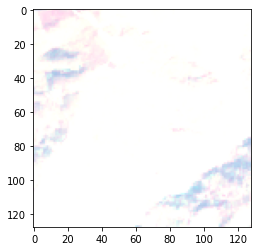

In [44]:
import matplotlib.pyplot as plt
plt.imshow(image[:,:,[4,3,1]])

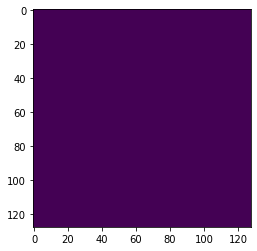

In [45]:
plt.imshow(label)